# **DIffusion : Implementing With CNN**


# **Gambaran Umum Proses Difusi :**


![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*SZoeIMeNdh7q_ciamuoweA.gif)

# **Ide dasar :** 

![](https://learnopencv.com/wp-content/uploads/2023/02/denoising-diffusion-probabilistic-models-forward_and_backward_equations.png)

# **ATAU LEBIH SIMPELNYA :**


![](https://www.researchgate.net/publication/371311491/figure/fig1/AS:11431281165411111@1686021694023/The-forward-and-reverse-processes-of-diffusion-models.ppm)

**Asli --> Noise**

**Noise --> Asli**

**Dengan Begitu :**

Bisa menggunakan Konsep Deep Learning

**UNTUK :** meningkatkan kualitas gambar (dari penuh noise menjadi gambar jernih)

# **alur idenya:**

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*m7twgbm24be19Md5AK6nfw.png)

# **LEBIH JELASNYA :**

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*KkxAfGzDNOpOQfPcEn-ldw.png)

### **Model Berusaha Menghilangkan Kembali Noise - Memperkirakan data sebelum di beri Noise**

# **Menerapkan Proses Difusi Sederhana**

Kita Perlu : 

* Data : Gambar Noise yang perlu Diproses. CIFAR-10 oleh tensoflow.keras (mobil)
* Timestamp : Untuk memberi tahu model status Noise, agar lebih mudah dipelajari.

## **1. Modul** 

In [6]:
import numpy as np

from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10

# **2. Membagi Dataset**

In [10]:
import pickle
import numpy as np
import os

def load_cifar10_batch(file):
    with open(file, 'rb') as f:
        batch = pickle.load(f, encoding='latin1')
        images = batch['data']
        labels = batch['labels']
        images = images.reshape((len(images), 3, 32, 32))
        images = np.transpose(images, (0, 2, 3, 1))  # Convert to HWC format
        return images, np.array(labels)

def load_cifar10_data(data_dir):
    # Load training data
    x_train, y_train = [], []
    for batch_id in range(1, 6):
        file = os.path.join(data_dir, f'data_batch_{batch_id}')
        images, labels = load_cifar10_batch(file)
        x_train.append(images)
        y_train.append(labels)
    x_train = np.vstack(x_train)
    y_train = np.concatenate(y_train)

    # Load test data
    test_file = os.path.join(data_dir, 'test_batch')
    x_test, y_test = load_cifar10_batch(test_file)

    # Load the label names
    with open(os.path.join(data_dir, 'batches.meta'), 'rb') as f:
        meta = pickle.load(f, encoding='latin1')
        label_names = meta['label_names']

    return (x_train, y_train), (x_test, y_test), label_names

# Define the directory containing the extracted CIFAR-10 files
cifar10_dir = r'/Users/ryanakmalpasya/Documents/[1] BS/[2] Freelance/PROJECTS/[1] EMERGING/[2] AI/[3] CV Adv/Generative Models/Diffusion Models/cifar-10-batches-py'

# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test), label_names = load_cifar10_data(cifar10_dir)

# Normalize pixel values to [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

print(f"Loaded CIFAR-10 dataset with labels: {label_names}")


Loaded CIFAR-10 dataset with labels: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [11]:
IMG_SIZE = 32     # input image size, CIFAR-10 is 32x32
BATCH_SIZE = 128  # for training batch size
timesteps = 16    # how many steps for a noisy image into clear
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1) # linspace for timesteps

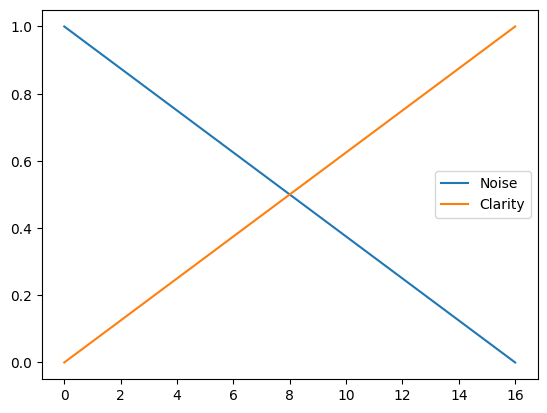

In [12]:
plt.plot(time_bar, label='Noise')
plt.plot(1 - time_bar, label='Clarity')
plt.legend()

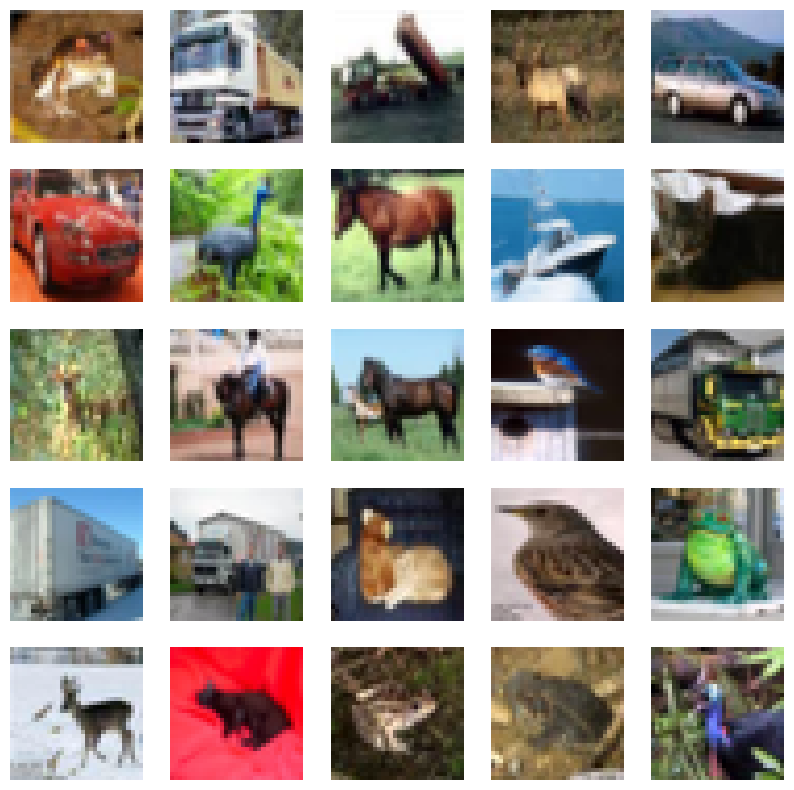

In [13]:
def cvtImg(img):
    img = img - img.min()
    img = (img / img.max())
    return img.astype(np.float32)

def show_examples(x):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img = cvtImg(x[i])
        plt.imshow(img)
        plt.axis('off')

show_examples(X_train)

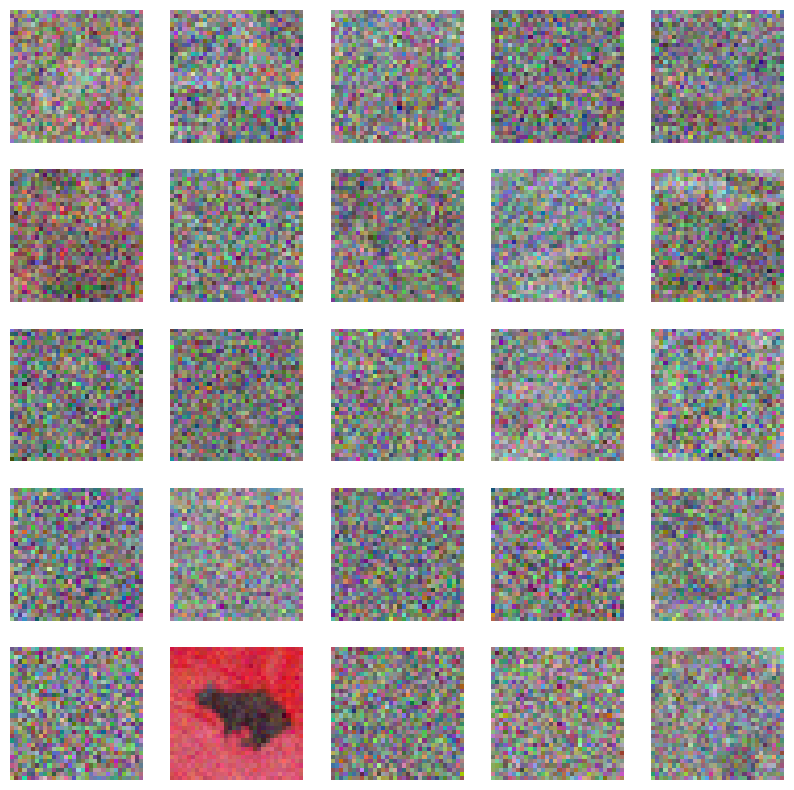

In [14]:
def forward_noise(x, t):
    a = time_bar[t]      # base on t
    b = time_bar[t + 1]  # image for t + 1
    
    noise = np.random.normal(size=x.shape)  # noise mask
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b
    return img_a, img_b
    
def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)

# t = np.full((25,), timesteps - 1) # if you want see clarity
# t = np.full((25,), 0)             # if you want see noisy
t = generate_ts(25)             # random for training data
a, b = forward_noise(X_train[:25], t)
show_examples(a)

In [15]:
def block(x_img, x_ts):
    x_parameter = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)
    x_parameter = layers.Activation('relu')(x_parameter)

    time_parameter = layers.Dense(128)(x_ts)
    time_parameter = layers.Activation('relu')(time_parameter)
    time_parameter = layers.Reshape((1, 1, 128))(time_parameter)
    x_parameter = x_parameter * time_parameter
    
    # -----
    x_out = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)
    x_out = x_out + x_parameter
    x_out = layers.LayerNormalization()(x_out)
    x_out = layers.Activation('relu')(x_out)
    
    return x_out

In [16]:
def make_model():
    x = x_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='x_input')
    
    x_ts = x_ts_input = layers.Input(shape=(1,), name='x_ts_input')
    x_ts = layers.Dense(192)(x_ts)
    x_ts = layers.LayerNormalization()(x_ts)
    x_ts = layers.Activation('relu')(x_ts)
    
    # ----- left ( down ) -----
    x = x32 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)
    
    x = x16 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)
    
    x = x8 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)
    
    x = x4 = block(x, x_ts)
    
    # ----- MLP -----
    x = layers.Flatten()(x)
    x = layers.Concatenate()([x, x_ts])
    x = layers.Dense(128)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Dense(4 * 4 * 32)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Reshape((4, 4, 32))(x)
    
    # ----- right ( up ) -----
    x = layers.Concatenate()([x, x4])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)
    
    x = layers.Concatenate()([x, x8])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)
    
    x = layers.Concatenate()([x, x16])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)
    
    x = layers.Concatenate()([x, x32])
    x = block(x, x_ts)
    
    # ----- output -----
    x = layers.Conv2D(3, kernel_size=1, padding='same')(x)
    model = tf.keras.models.Model([x_input, x_ts_input], x)
    return model

model = make_model()
# model.summary()

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
loss_func = tf.keras.losses.MeanAbsoluteError()
model.compile(loss=loss_func, optimizer=optimizer)

  0%|          | 0/16 [00:00<?, ?it/s]

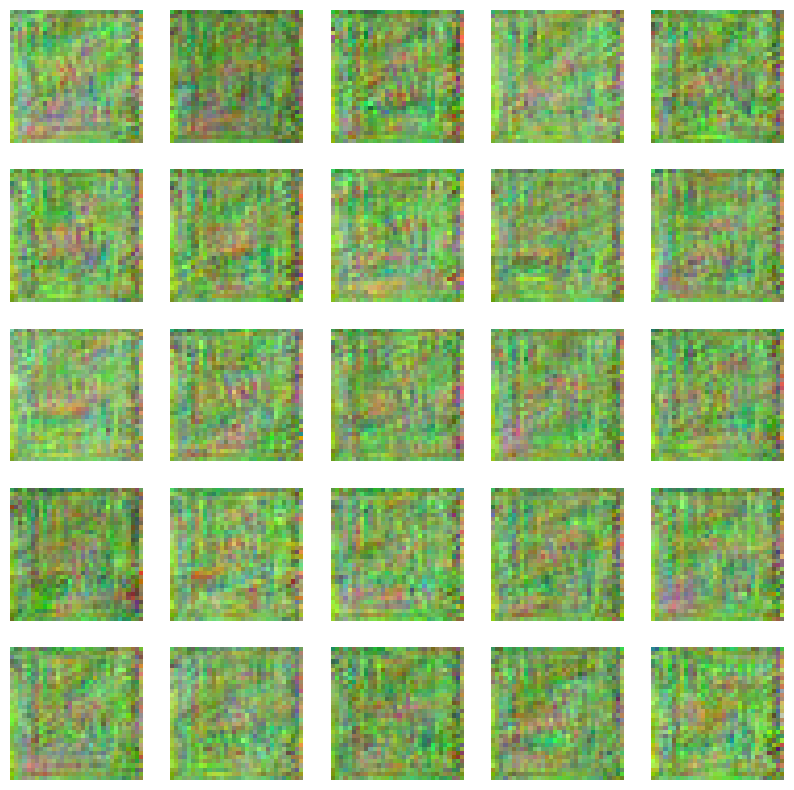

In [18]:
def predict(x_idx=None):
    x = np.random.normal(size=(32, IMG_SIZE, IMG_SIZE, 3))
    for i in trange(timesteps):
        t = i
        x = model.predict([x, np.full((32), t)], verbose=0)
    show_examples(x)

predict()

  0%|          | 0/16 [00:00<?, ?it/s]

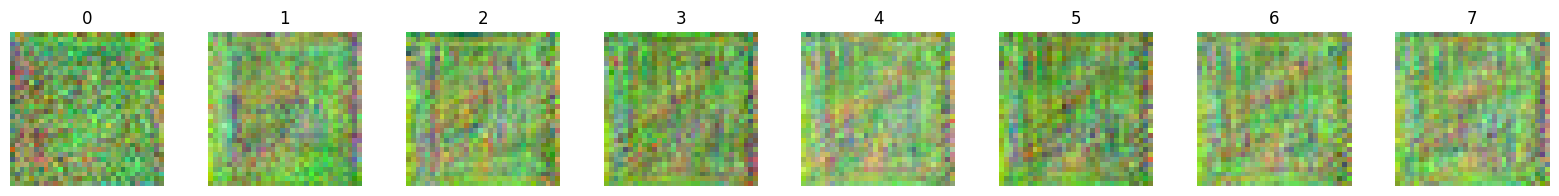

In [19]:
def predict_step():
    xs = []
    x = np.random.normal(size=(8, IMG_SIZE, IMG_SIZE, 3))

    for i in trange(timesteps):
        t = i
        x = model.predict([x, np.full((8),  t)], verbose=0)
        if i % 2 == 0:
            xs.append(x[0])

    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(cvtImg(xs[i]))
        plt.title(f'{i}')
        plt.axis('off')

predict_step()

In [20]:
def train_one(x_img):
    x_ts = generate_ts(len(x_img))
    x_a, x_b = forward_noise(x_img, x_ts)
    loss = model.train_on_batch([x_a, x_ts], x_b)
    return loss

In [21]:
def train(R=50):
    bar = trange(R)
    total = 100
    for i in bar:
        for j in range(total):
            x_img = X_train[np.random.randint(len(X_train), size=BATCH_SIZE)]
            loss = train_one(x_img)
            pg = (j / total) * 100
            if j % 5 == 0:
                bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')

In [ ]:
import os

# directory to save models
save_dir = 'model_checkpoints'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for epoch in range(10):
    train()

    # reduce learning rate for next training
    model.optimizer.learning_rate = max(0.000001, model.optimizer.learning_rate * 0.9)

    # show result
    predict()
    predict_step()
    plt.show()

    # save model
    model.save(os.path.join(save_dir, f'model_epoch_{epoch+1}.h5'))


In [ ]:
for _ in range(10):
    train()
    # reduce learning rate for next training
    model.optimizer.learning_rate = max(0.000001, model.optimizer.learning_rate * 0.9)

    # show result 
    predict()
    predict_step()
    plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]